In [5]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun

In [6]:
load_dotenv()
#openai_model=ChatOpenAI(model="gpt-3.5-turbo")
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [7]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.084525004, 'prompt_time': 0.0093531, 'queue_time': 0.278644969, 'total_time': 0.093878104}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_0595f8b215', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--42576cfa-a9f3-44bf-a482-75e7fb085406-0', usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20})

In [8]:
#openai_model.invoke("hi")

In [9]:
search_tool=DuckDuckGoSearchRun()

In [10]:
search_tool.invoke("what is a GDP of Sri Lanka?")

"The mixed economy of Sri Lanka was valued at LKR 29.89 trillion (around $99 billion) in 2024 by gross domestic product ( GDP ) and $342.6 billion by purchasing power parity (PPP) [5] Sri Lanka's economy expanded by 5.0% in 2024, [5][4] marking a strong recovery from the 2022 economic crisis. The Gross Domestic Product ( GDP ) in Sri Lanka was worth 98.96 billion US dollars in 2024, according to official data from the World Bank. The GDP value of Sri Lanka represents 0.09 percent of the world economy. Current and historical Gross Domestic Product ( GDP ) of Sri Lanka in nominal and real US dollar values. GDP growth rates and charts See full list on worldometers.info Sri Lanka GDP for 2020 was 84.30 billion US dollars, a 5.29% decline from 2019. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. Gross Domestic Product National Accounts Estimates - 1st

In [11]:
repl=PythonREPL()

In [12]:
code = """
x = 5
y = x * 2
print(y)
"""

In [13]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [21]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Acer NItro 5\AppData\Local\Temp\ipykernel_1772\2549763978.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Acer NItro 5\AppData\Local\Temp\ipykernel_1772\2549763978.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [15]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [16]:
make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [17]:
"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [18]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [19]:
research_agent = create_react_agent(
    #openai_model,
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [22]:
chart_agent = create_react_agent(
    #openai_model,
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [23]:
state={"message":["hi","hello"]}

In [ ]:
state["message"][-1]

'hello'

In [24]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [25]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [26]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

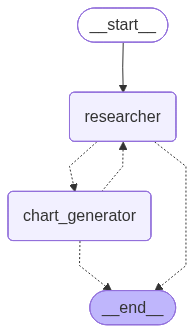

In [27]:
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='220d9c8d-d78e-47d7-b6c0-be0c1eab1f3a'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, I need to figure out how to get the UK\'s GDP for the past three years and then create a line chart based on that data. \n\nFirst, I realize I don\'t have the GDP data readily available. Since I\'m an AI, I can\'t access real-time data directly, so I\'ll need to use a tool to look it up. I remember that the user has provided a tool called DuckDuckGo Search which can help with current event queries. \n\nI\'ll start by crafting a search query that DuckDuckGo can use to find the GDP data. The query should be specific enough to get relevant results, so I\'ll use something like "UK GDP past three years." This should bring up the latest information from reliable sources.\n\nOnce I have the searc